# **INSTALL LIBRARY**

In [1]:
!pip install replicate --quiet
!pip install langchain_community --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import pandas as pd
import os
from google.colab import userdata
from langchain_community.llms import Replicate

# **MENYIAPKAN DATA**

In [3]:
df = pd.read_csv('/content/Data AC.csv')
print(df.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')


In [4]:
import plotly.express as px

df = df[['content', 'score', 'at']]

# Reset index agar rapi
df = df.reset_index(drop=True)

print(f"Jumlah data setelah difilter kolom: {len(df)}")
print("Data berhasil disimpan ke pintu_filtered.csv")
df.head()

score_counts = df["score"].value_counts().sort_index()

fig = px.bar(
    x=score_counts.index,
    y=score_counts.values,
    text=score_counts.values,
    labels={"x": "Skor", "y": "Jumlah"},
    title="Distribusi Skor Bintang",
    color=score_counts.index.astype(str),  # warna berbeda tiap skor
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Tampilkan angka di atas batang
fig.update_traces(textposition="outside")

# Layout lebih clean
fig.update_layout(
    xaxis=dict(title="Skor", tickmode="linear"),
    yaxis=dict(title="Jumlah"),
    title=dict(x=0.5, font=dict(size=18)),
    showlegend=False
)
fig.show()

# Simpan hasil ke file baru
df.to_csv('/content/AC Filter.csv', index=False)

Jumlah data setelah difilter kolom: 2562
Data berhasil disimpan ke pintu_filtered.csv


# **PREPROCESSING TEKS**

**Case Folding**

In [5]:
df['case_folding'] = df['content'].astype(str).str.lower() # Buat kolom baru 'case_folding' dari kolom 'content'
df[['content', 'case_folding']].head() # Tampilkan hasil sebelum dan sesudah case folding untuk contoh 5 data

,content,case_folding
0,calls banyak salahnya,calls banyak salahnya
1,"ini aplikasi utk yg sudah jadi member,, bukan ...","ini aplikasi utk yg sudah jadi member,, bukan ..."
2,miris anjay lihat ratingnya,miris anjay lihat ratingnya
3,scam.,scam.
4,"ulasannya, lihat aja ratingnya sudah sangat me...","ulasannya, lihat aja ratingnya sudah sangat me..."


In [6]:
df.to_csv('/content/AC casefolding.csv', index=False)
print("✅ File berhasil disimpan sebagai 'AC casefolding.csv'")

✅ File berhasil disimpan sebagai 'AC casefolding.csv'


**Cleaning**

In [7]:
import re

def clean_text(text): # Fungsi cleaning
    text = str(text).lower()  # Lowercase
    text = re.sub(r'(?<=[\w])([.,!?;:])(?=[\w])', r' \1 ', text) # Tambahkan spasi jika simbol seperti titik, koma, tanda seru menempel di antara huruf
    text = re.sub(r'\.{2,}', ' ', text)                  # Ganti dua titik atau lebih dengan spasi
    text = re.sub(r'[-_]', ' ', text)                    # Ganti - dan _ dengan spasi
    text = re.sub(r'http\S+|www.\S+', ' ', text)         # Hapus URL
    text = re.sub(r'<.*?>', ' ', text)                   # Hapus tag HTML
    text = re.sub(r'@\w+', ' ', text)                    # Hapus mention
    text = re.sub(r'#\S+', '', text)                     # Ambil kata dari hashtag
    text = re.sub(r'[²³¹⁰⁴⁵⁶⁷⁸⁹⁺⁻⁼]', ' ', text)         # Hapus karakter superscript
    text = re.sub(r'[\(\)\[\]]', ' ', text)              # Hapus tanda kurung dan ganti dengan spasi
    text = re.sub(
        r'[^\w\s\u263a-\u263c\u2600-\u26FF\u2700-\u27BF\U0001F300-\U0001FAFF]',
        ' ', text)                                       # Hapus simbol non-emoji (kecuali huruf, angka, dan emoji unicode)
    text = re.sub(r'\s+', ' ', text).strip()             # Rapikan spasi
    return text

df['cleaned'] = df['case_folding'].apply(clean_text) # Tambahkan fungsi ke kolom 'case_folding'
print("Contoh hasil cleaning:")
print(df[['case_folding', 'cleaned']].head())

Contoh hasil cleaning:
                                        case_folding  \
0                              calls banyak salahnya   
1  ini aplikasi utk yg sudah jadi member,, bukan ...   
2                        miris anjay lihat ratingnya   
3                                              scam.   
4  ulasannya, lihat aja ratingnya sudah sangat me...   

                                             cleaned  
0                              calls banyak salahnya  
1  ini aplikasi utk yg sudah jadi member bukan ut...  
2                        miris anjay lihat ratingnya  
3                                               scam  
4  ulasannya lihat aja ratingnya sudah sangat men...  


In [8]:
df.to_csv('/content/AC cleaning.csv', index=False)
print("✅ File berhasil disimpan sebagai 'AC cleaning.csv'")

✅ File berhasil disimpan sebagai 'AC cleaning.csv'


**Hapus Duplikasi Data**

In [9]:
df = df.drop_duplicates(subset='cleaned', keep='first').reset_index(drop=True) # Hapus duplikasi berdasarkan kolom 'cleaned'
print(f"Jumlah data setelah hapus duplikasi: {len(df)}")
print(df[['cleaned']].head())

df.to_csv('/content/AC hapus duplikasi data.csv', index=False) # Simpan hasil untuk mengecek apakah sudah ulasan yang duplikat sudah dihapus

Jumlah data setelah hapus duplikasi: 2423
                                             cleaned
0                              calls banyak salahnya
1  ini aplikasi utk yg sudah jadi member bukan ut...
2                        miris anjay lihat ratingnya
3                                               scam
4  ulasannya lihat aja ratingnya sudah sangat men...


# **KONEKSI API UNTUK MELANJUTKAN ANALISIS SENTIMEN**

In [10]:
from langchain_community.llms import Replicate

#ambil api token
api_token = userdata.get('api_token')

#lempar token ke env var
os.environ['REPLICATE_API_TOKEN'] = api_token

# Define llm ibm-granite
llm = Replicate(model="ibm-granite/granite-3.3-8b-instruct")

In [11]:
def classify_sentiment(review):
    prompt = f"""
    Kamu adalah sistem analisis sentimen untuk ulasan aplikasi Akademi Crypto di Google Play Store.
    Tugasmu adalah mengklasifikasikan teks ulasan berikut ke dalam salah satu kategori:
    - Positif → jika ulasan berisi kata-kata pujian, kepuasan, rekomendasi, atau pengalaman menyenangkan.
    - Negatif → jika ulasan berisi keluhan, kata kasar, kekecewaan, atau pengalaman buruk.
    - Netral  → jika ulasan ambigu, hanya bertanya, bersifat deskriptif, atau tidak menunjukkan emosi jelas.

    Aturan penting:
    - Jawaban harus hanya salah satu kata persis: "Positif", "Negatif", atau "Netral".
    - Jangan menambahkan penjelasan lain.
    - Jika ulasan singkat seperti "bagus" → Positif.
    - Jika ulasan singkat seperti "sampah" atau "jelek" → Negatif.
    - Jika ulasan hanya informasi, misalnya "update ke versi terbaru" → Netral.

    Ulasan: "{review}"

    Jawaban:
    """
    try:
        result = llm.invoke(prompt)
        result = result.strip().lower()
        if "positif" in result:
            return "Positif"
        elif "negatif" in result:
            return "Negatif"
        else:
            return "Netral"
    except Exception as e:
        return "Error"

In [12]:
df["sentiment"] = df["cleaned"].apply(classify_sentiment)

# simpan hasil analisis ke file terpisah sesuai label
df[df["sentiment"]=="Positif"].to_csv("Sentimen positif.csv", index=False)
df[df["sentiment"]=="Negatif"].to_csv("Sentimen negatif.csv", index=False)
df[df["sentiment"]=="Netral"].to_csv("Sentimen netral.csv", index=False)

print(df["sentiment"].value_counts())

sentiment
Positif    1314
Negatif     884
Netral      225
Name: count, dtype: int64


In [13]:
# ambil hanya kolom yang dibutuhkan dan ubah nama 'cleaned' -> 'ulasan'
selected_cols = df[["cleaned", "score", "sentiment"]].rename(columns={"cleaned": "ulasan"})

# simpan hasil analisis ke file terpisah sesuai label
selected_cols[selected_cols["sentiment"]=="Positif"].to_csv("Hasil Sentimen positif.csv", index=False)
selected_cols[selected_cols["sentiment"]=="Negatif"].to_csv("Hasil Sentimen negatif.csv", index=False)
selected_cols[selected_cols["sentiment"]=="Netral"].to_csv("Hasil Sentimen netral.csv", index=False)

print("ketiga sentimen sudah disimpan")

ketiga sentimen sudah disimpan


In [14]:
df_pos = pd.read_csv("Hasil Sentimen positif.csv")
df_neg = pd.read_csv("Hasil Sentimen negatif.csv")
df_net = pd.read_csv("Hasil Sentimen netral.csv")

# Tampilkan masing-masing 5 data
print("=== 5 Data Sentimen Positif ===")
display(df_pos.head())

print("\n=== 5 Data Sentimen Negatif ===")
display(df_neg.head())

print("\n=== 5 Data Sentimen Netral ===")
display(df_net.head())

=== 5 Data Sentimen Positif ===


,ulasan,score,sentiment
0,sangat bagus dan berkualitas,5,Positif
1,bagusan pakai x katanya aplikasi sekelas bloom...,1,Positif
2,aplikasi ini sangat membantu saya untuk mendap...,5,Positif
3,kalo kalian pengen kaya dengan crypto jangan p...,1,Positif
4,terbaik ac modulnya super lengkap heran sama o...,5,Positif



=== 5 Data Sentimen Negatif ===


,ulasan,score,sentiment
0,calls banyak salahnya,1,Negatif
1,ini aplikasi utk yg sudah jadi member bukan ut...,5,Negatif
2,scam,1,Negatif
3,mau2 nya dikibulin bocah tengil sitimoty ronal...,1,Negatif
4,ac komunitas paling sampah pump dump aja kerja...,1,Negatif



=== 5 Data Sentimen Netral ===


,ulasan,score,sentiment
0,miris anjay lihat ratingnya,1,Netral
1,ulasannya lihat aja ratingnya sudah sangat men...,1,Netral
2,aplikasi golbok,1,Netral
3,gimana nih aplikasi,1,Netral
4,aela buntung,1,Netral


In [15]:
import plotly.express as px

# Hitung distribusi sentimen
sentiment_counts = df["sentiment"].value_counts()

# Buat pie chart interaktif
fig = px.pie(
    values=sentiment_counts.values,
    names=sentiment_counts.index,
    title="Distribusi Sentimen Ulasan Akademi Crypto",
    color=sentiment_counts.index,
    color_discrete_sequence=px.colors.qualitative.Set2,  # palet modern
    hole=0.5  # jika ingin tampilan donat (opsional)
)

# Atur layout agar lebih clean
fig.update_traces(textinfo="percent+label", pull=[0.05]*len(sentiment_counts))
fig.update_layout(title=dict(x=0.5, font=dict(size=18, family="Times New Roman", color="black")))

# Tampilkan
fig.show()


# **TRAINING MENGGUNAKAN SVM**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

X = df['cleaned']
y = df['sentiment']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Inisialisasi dan latih model
svm_model = LinearSVC(class_weight="balanced", random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi data uji
y_pred = svm_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Hasil Evaluasi SVM")
print(f"Akurasi   : {accuracy:.4f}")
print(f"Presisi   : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Hasil Evaluasi SVM
Akurasi   : 0.8536
Presisi   : 0.8596
Recall    : 0.8536
F1-Score  : 0.8530

📋 Classification Report:
              precision    recall  f1-score   support

     Negatif       0.77      0.92      0.84       161
      Netral       0.58      0.47      0.52        38
     Positif       0.95      0.87      0.91       286

    accuracy                           0.85       485
   macro avg       0.77      0.75      0.76       485
weighted avg       0.86      0.85      0.85       485



# **HASIL VISUALISASI**

In [17]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import numpy as np

# Label urutan tetap
labels = ['Negatif', 'Netral', 'Positif']

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Tentukan warna teks berdasarkan threshold
threshold = cm.max() / 2  # ambil setengah nilai maksimum
text_colors = [["white" if cm[i, j] > threshold else "black" for j in range(len(labels))]
               for i in range(len(labels))]

# Plot Heatmap
fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=labels,
    y=labels,
    colorscale="YlGnBu",
    showscale=True,
    hovertemplate="True: %{y}<br>Pred: %{x}<br>Jumlah: %{z}<extra></extra>"
))

# Tambahkan anotasi manual agar bisa kontrol warna teks
for i in range(len(labels)):
    for j in range(len(labels)):
        fig.add_annotation(
            dict(
                x=labels[j],
                y=labels[i],
                text=str(cm[i, j]),
                showarrow=False,
                font=dict(color=text_colors[i][j], size=14)
            )
        )

fig.update_layout(
    title=dict(
        text="Confusion Matrix - SVM Sentiment Classification",
        x=0.5,
        xanchor="center",
        font=dict(size=16, family="Arial", color="black")
    ),
    xaxis_title="Predicted Label",
    yaxis_title="True Label",
    xaxis=dict(side="bottom"),
    width=600,
    height=500,
    font=dict(size=12)
)

fig.show()


In [18]:
import plotly.express as px

df["at"] = pd.to_datetime(df["at"])
df["month"] = df["at"].dt.to_period("M")

trend = df.groupby(["month", "sentiment"]).size().unstack(fill_value=0)

trend_reset = trend.reset_index()
trend_reset["month"] = trend_reset["month"].astype(str)  # konversi ke string agar rapi

# Ubah ke format long
trend_melt = trend_reset.melt(id_vars="month", var_name="sentiment", value_name="jumlah")

# Buat visualisasi interaktif
fig = px.line(
    trend_melt,
    x="month",
    y="jumlah",
    color="sentiment",
    markers=True,
    title="Tren Sentimen per Bulan"
)

fig.update_layout(
    xaxis_title="Bulan",
    yaxis_title="Jumlah Ulasan",
    legend_title="Sentimen",
    title=dict(x=0.5, font=dict(size=18)),
    template="plotly_white"
)

fig.show()


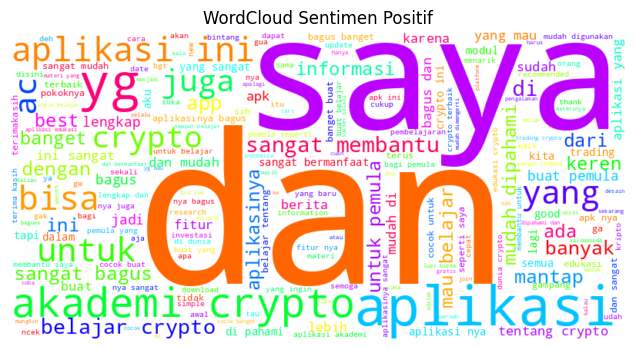

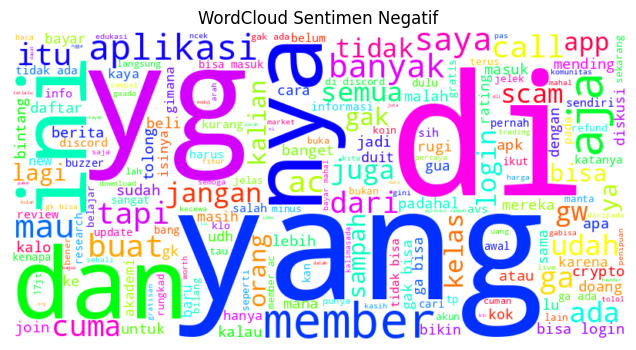

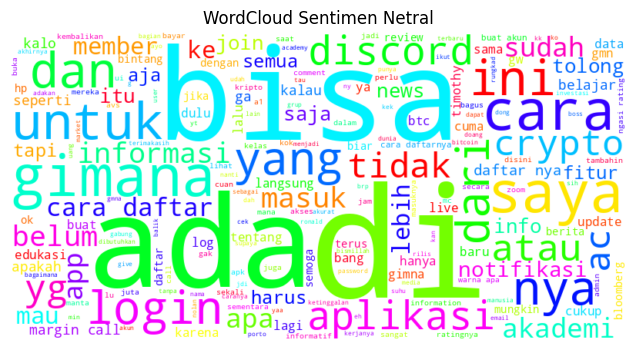

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Fungsi untuk menghasilkan warna acak
def random_color_func(*args, **kwargs):
    return "hsl({}, 100%, 50%)".format(random.randint(0, 360))

for label in ["Positif", "Negatif", "Netral"]:
    text = " ".join(df[df["sentiment"]==label]["cleaned"])
    wc = WordCloud(width=800, height=400, background_color="white", color_func=random_color_func).generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud Sentimen {label}")
    plt.show()